# Import Required Libraries
Import necessary libraries such as pandas, numpy, matplotlib, seaborn, and surprise.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD, KNNBasic, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
import ipywidgets as widgets
from IPython.display import display

# Load and Explore Data
Load the movies, ratings, tags, and links datasets. Display the first few rows of each dataset to understand their structure.

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


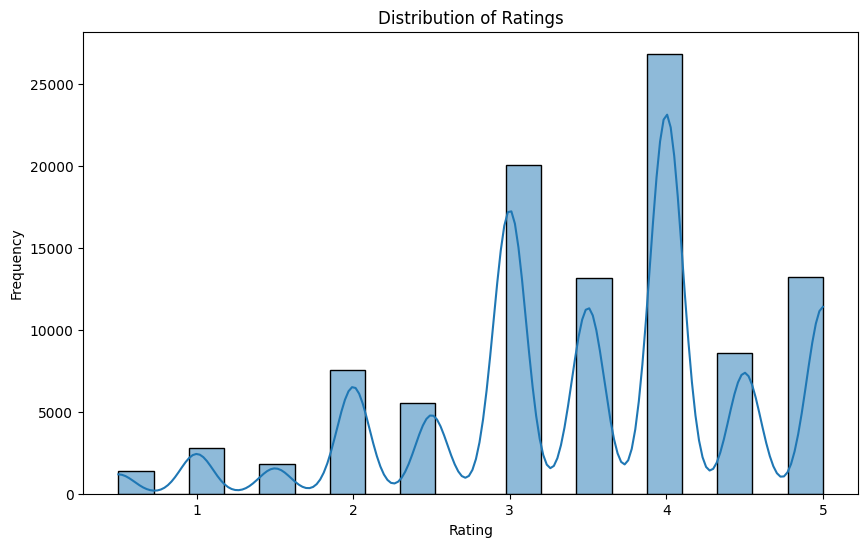

In [2]:
# Load datasets
movies = pd.read_csv('./ml-latest-small/movies.csv')
ratings = pd.read_csv('./ml-latest-small/ratings.csv')
tags = pd.read_csv('./ml-latest-small/tags.csv')
links = pd.read_csv('./ml-latest-small/links.csv')

# Display first few rows
display(movies.head(), ratings.head(), tags.head(), links.head())

# Visualize data distributions
plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Preprocess Data
Preprocess the data by merging datasets, handling missing values, and encoding categorical variables.

In [3]:
# Merge datasets
movies_links = pd.merge(movies, links, on='movieId')
ratings_movies = pd.merge(ratings, movies_links, on='movieId')
tags_movies = pd.merge(tags, movies_links, on='movieId')

# Handle missing values
ratings_movies.fillna({'tag': ''}, inplace=True)

# Encode genres
ratings_movies['genres'] = ratings_movies['genres'].apply(lambda x: x.split('|'))
all_genres = set([genre for sublist in ratings_movies['genres'] for genre in sublist])
for genre in all_genres:
    ratings_movies[genre] = ratings_movies['genres'].apply(lambda x: int(genre in x))

# Drop unnecessary columns
ratings_movies.drop(columns=['timestamp', 'genres', 'imdbId', 'tmdbId'], inplace=True)

# Display preprocessed data
display(ratings_movies.head())

,userId,movieId,rating,title,Horror,War,Action,Animation,Fantasy,Mystery,...,Film-Noir,(no genres listed),Documentary,Adventure,Thriller,Western,Comedy,Musical,Children,Sci-Fi
0,1,1,4.0,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,1,0,0,1,0,1,0
1,5,1,4.0,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,1,0,0,1,0,1,0
2,7,1,4.5,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,1,0,0,1,0,1,0
3,15,1,2.5,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,1,0,0,1,0,1,0
4,17,1,4.5,Toy Story (1995),0,0,0,1,1,0,...,0,0,0,1,0,0,1,0,1,0


# Visualize Data
Create visualizations to understand the distribution of ratings, the number of ratings per movie, and the number of ratings per user.

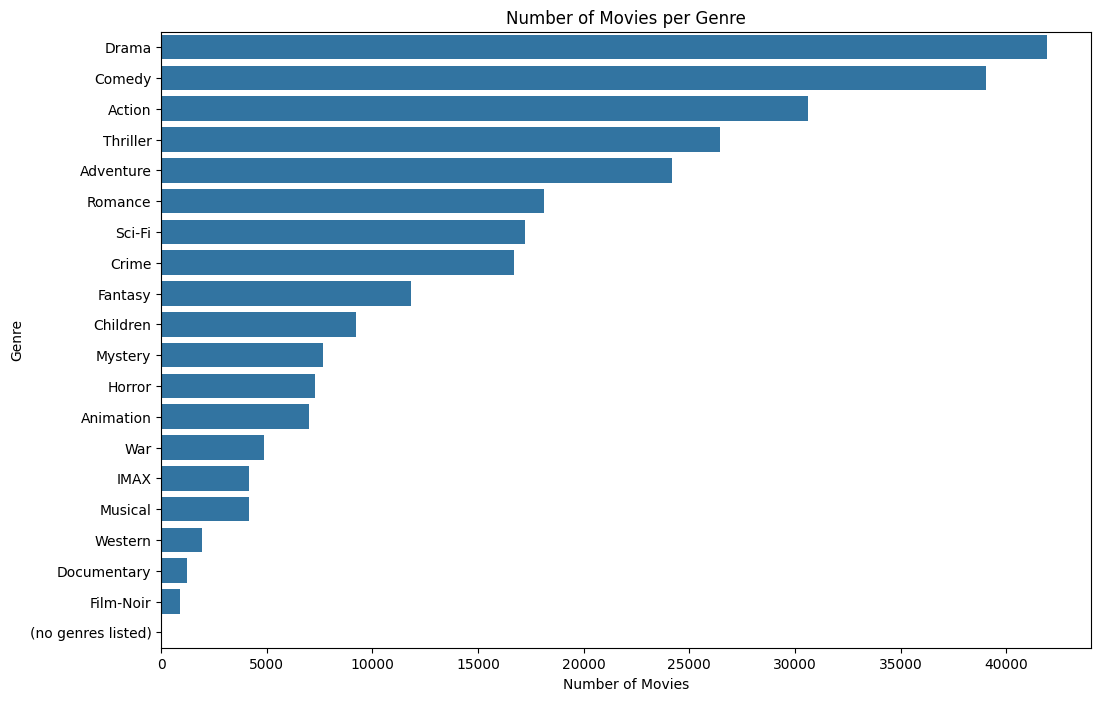

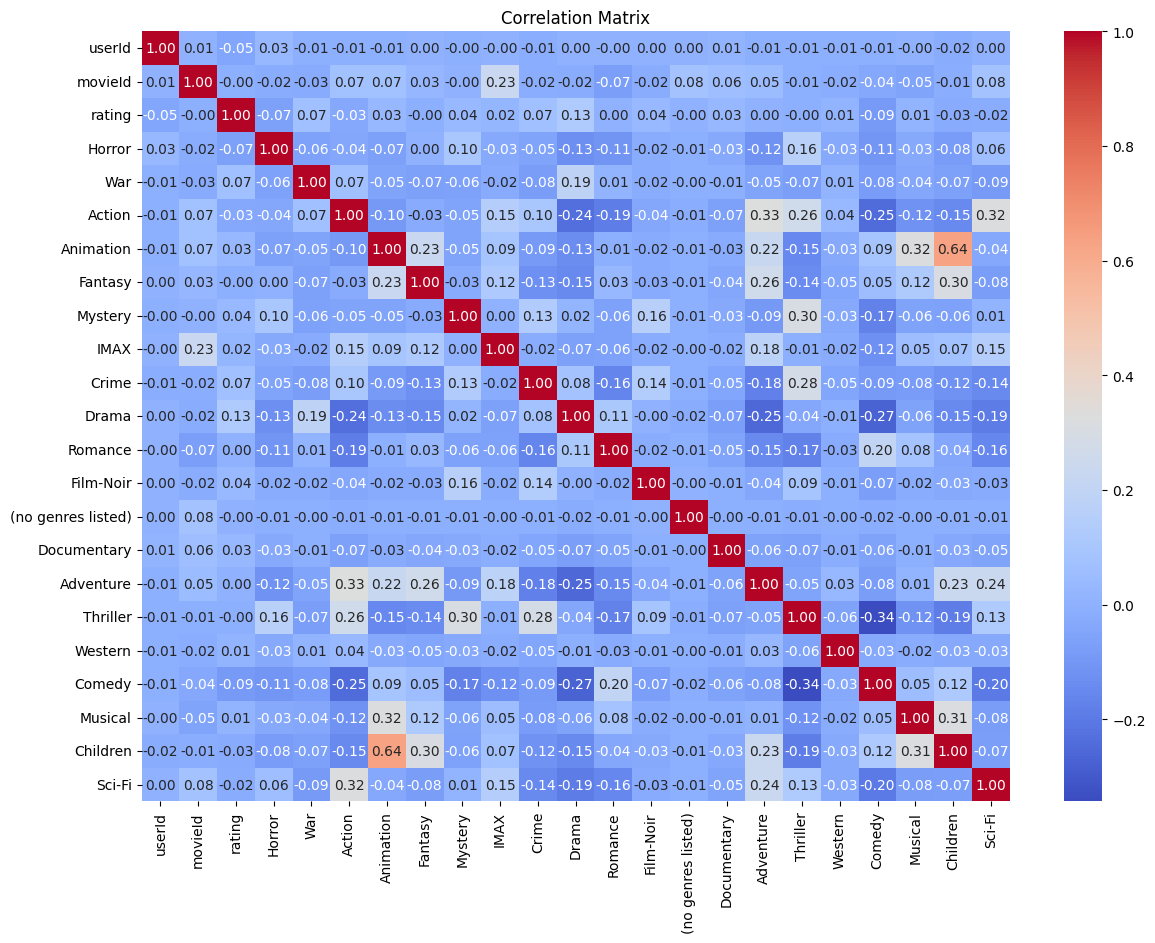

In [4]:
# Visualize number of movies per genre
genre_counts = ratings_movies[list(all_genres)].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Number of Movies per Genre')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

# Visualize correlation matrix
plt.figure(figsize=(14, 10))
numeric_cols = ratings_movies.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Train Collaborative Filtering Model
Use the Surprise library to train a collaborative filtering model (e.g., SVD) on the preprocessed data.

In [5]:
# Prepare data for Surprise library
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Train SVD model
svd_model = SVD()
cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Train KNN model
knn_model = KNNBasic()
cross_validate(knn_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Hyperparameter tuning for SVD
param_grid = {'n_epochs': [20, 30], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8792  0.8773  0.8767  0.8662  0.8662  0.8731  0.0057  
MAE (testset)     0.6726  0.6745  0.6718  0.6667  0.6687  0.6708  0.0028  
Fit time          1.05    1.11    1.18    1.14    1.13    1.12    0.04    
Test time         0.20    0.12    0.19    0.13    0.21    0.17    0.04    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9552  0.9460  0.9506  0.9408  0.9452  0.9476  0.0049

# Evaluate Model
Evaluate the model using metrics such as RMSE and visualize the results.

RMSE: 0.8760


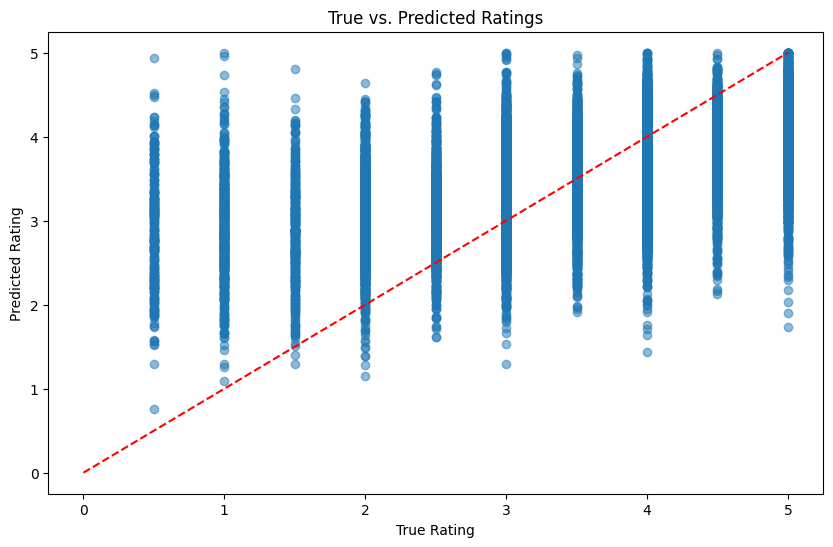

In [6]:

# Split data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train and evaluate SVD model
svd_model.fit(trainset)
predictions = svd_model.test(testset)
accuracy.rmse(predictions)

# Visualize true vs. predicted ratings
true_ratings = [pred.r_ui for pred in predictions]
predicted_ratings = [pred.est for pred in predictions]
plt.figure(figsize=(10, 6))
plt.scatter(true_ratings, predicted_ratings, alpha=0.5)
plt.plot([0, 5], [0, 5], color='red', linestyle='--')
plt.title('True vs. Predicted Ratings')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.show()

# Make Recommendations
Use the trained model to make movie recommendations for a given user and visualize the recommended movies.

Top 10 movie recommendations for user 1:
1. Usual Suspects, The (1995) (Predicted Rating: 5.00, Genres: Crime|Mystery|Thriller)
2. Star Wars: Episode IV - A New Hope (1977) (Predicted Rating: 5.00, Genres: Action|Adventure|Sci-Fi)
3. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) (Predicted Rating: 5.00, Genres: Comedy|War)
4. 2001: A Space Odyssey (1968) (Predicted Rating: 5.00, Genres: Adventure|Drama|Sci-Fi)
5. Full Metal Jacket (1987) (Predicted Rating: 5.00, Genres: Drama|War)
6. Bridge on the River Kwai, The (1957) (Predicted Rating: 5.00, Genres: Adventure|Drama|War)
7. Lord of the Rings: The Fellowship of the Ring, The (2001) (Predicted Rating: 5.00, Genres: Adventure|Fantasy)
8. Spirited Away (Sen to Chihiro no kamikakushi) (2001) (Predicted Rating: 5.00, Genres: Adventure|Animation|Fantasy)
9. Dark Knight, The (2008) (Predicted Rating: 5.00, Genres: Action|Crime|Drama|IMAX)
10. Dark Knight Rises, The (2012) (Predicted Rating: 5.00, Genres: Action|

C:\Users\TonyZ\AppData\Local\Temp\ipykernel_12604\455664221.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='predicted_rating', y='title_with_genres', data=recommended_movies, palette='viridis')


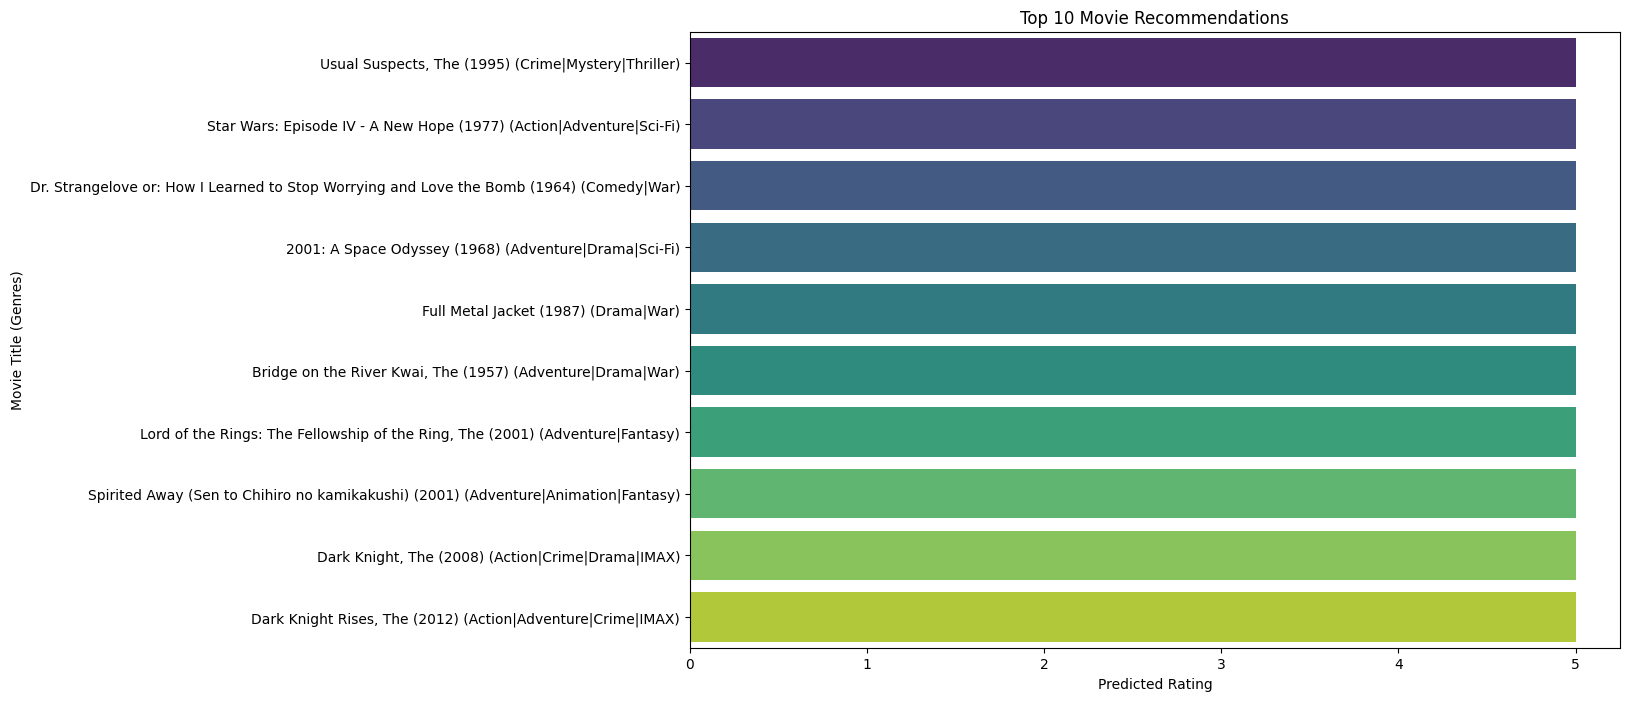

In [7]:
# Function to get top N movie recommendations for a given user
def get_top_n_recommendations(user_id, n=10):
    all_movie_ids = ratings['movieId'].unique()
    predictions = [svd_model.predict(user_id, movie_id) for movie_id in all_movie_ids]
    top_n_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    top_n_movie_ids = [pred.iid for pred in top_n_predictions]
    top_n_movies = movies[movies['movieId'].isin(top_n_movie_ids)]
    top_n_movie_titles = top_n_movies['title'].values
    top_n_movie_genres = top_n_movies['genres'].values
    return top_n_movie_titles, top_n_predictions, top_n_movie_genres

# Get top 10 movie recommendations for user with ID 1
user_id = 1
top_n_movie_titles, top_n_predictions, top_n_movie_genres = get_top_n_recommendations(user_id, n=10)

# Display recommended movies with reasons
print(f"Top 10 movie recommendations for user {user_id}:")
for i, (title, pred, genres) in enumerate(zip(top_n_movie_titles, top_n_predictions, top_n_movie_genres), 1):
    print(f"{i}. {title} (Predicted Rating: {pred.est:.2f}, Genres: {genres})")

# Prepare data for visualization
recommended_movies = pd.DataFrame({
    'title': top_n_movie_titles,
    'predicted_rating': [pred.est for pred in top_n_predictions],
    'genres': top_n_movie_genres
})
recommended_movies['title_with_genres'] = recommended_movies.apply(lambda x: f"{x['title']} ({x['genres']})", axis=1)

# Visualize recommended movies
plt.figure(figsize=(12, 8))
sns.barplot(x='predicted_rating', y='title_with_genres', data=recommended_movies, palette='viridis')
plt.title('Top 10 Movie Recommendations')
plt.xlabel('Predicted Rating')
plt.ylabel('Movie Title (Genres)')
plt.show()

# Interactive Interface
Interactive widgets for user input.

In [8]:
# Create interactive widgets for user input
user_id_widget = widgets.IntText(value=1, description='User ID:')
n_recommendations_widget = widgets.IntSlider(value=10, min=1, max=20, step=1, description='N Recommendations:')

def display_recommendations(user_id, n_recommendations):
    # Clear previous output
    plt.close('all')
    
    # Get recommendations
    top_n_movie_titles, top_n_predictions, top_n_movie_genres = get_top_n_recommendations(user_id, n=n_recommendations)
    
    # Print recommendations
    print(f"Top {n_recommendations} movie recommendations for user {user_id}:")
    for i, (title, pred, genres) in enumerate(zip(top_n_movie_titles, top_n_predictions, top_n_movie_genres), 1):
        print(f"{i}. {title} (Predicted Rating: {pred.est:.2f}, Genres: {genres})")
    
    # Prepare data for visualization
    recommended_movies = pd.DataFrame({
        'title_with_genres': [f"{title} ({genres})" for title, genres in zip(top_n_movie_titles, top_n_movie_genres)],
        'predicted_rating': [pred.est for pred in top_n_predictions]
    })
    
    # Create and display plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=recommended_movies,
        x='predicted_rating',
        y='title_with_genres',
        color='skyblue'
    )
    plt.title(f'Top {n_recommendations} Movie Recommendations')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Movie Title (Genres)')
    plt.tight_layout()
    plt.show()

# Create and display interactive widget
widgets.interactive(display_recommendations, 
                   user_id=user_id_widget, 
                   n_recommendations=n_recommendations_widget)

interactive(children=(IntText(value=1, description='User ID:'), IntSlider(value=10, description='N Recommendat…